In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.sparse.linalg import norm

In [2]:
import sys
sys.path.insert(0, "../scripts")

from SZFW_lasso import *
from DZFW_lasso import *
from IZFW_lasso import *

## Load data: Covtype Dataset

In [3]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [4]:
# space dimension
d = X.shape[1]
n = y.shape[0]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 54
n: 581012


In [5]:
# define the objective function
F = lambda w: 0.5/n * np.sum(np.power(y - X @ w, 2))

In [6]:
# initialize prarameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

# starting point: center
indeces = np.random.randint(low = 0, high = d-1, size = 20)
w0[indeces] = int(0)
w0 = np.zeros(d)
print(f"w0: {w0}")

w0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


## Deterministic Gradient Free Frank Wolfe on Covtype

In [7]:
%%time

# Lipschitz constant 
L = 3

fpred, f, w, mean, t, loss, f_values = detZFW(F, L, d, w0, T=5)

Loss evaluation at time 1:	0.7013836

Loss evaluation at time 2:	0.1212442

Loss evaluation at time 3:	0.0424383

Loss evaluation at time 4:	0.0199207

Loss evaluation at time 5:	0.0109946

CPU times: user 5.72 s, sys: 214 ms, total: 5.93 s
Wall time: 6 s


In [8]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.34641199738781203

F(w) = 0.3354173784042209

w = [0.         0.         0.         0.         0.         0.
 0.         0.95238095 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]

average w = [0.         0.         0.         0.         0.         0.
 0.         0.85714286 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

In [9]:
lossd = np.load("../Data/results/loss_dZFW_lasso.npy") # data from colab (NOT NORMALIZED)
f_d = np.load("../Data/results/function_dZFW_lasso.npy")
f_d = f_d/n
f_star = np.min(f_d)
lossd = lossd/n

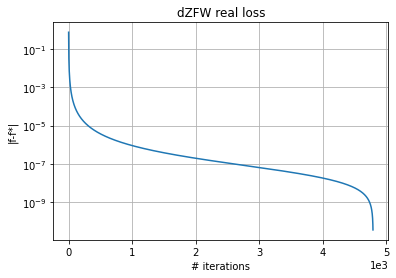

In [10]:
F_evald = np.abs(f_d - f_star)
F_evald = F_evald[:-2]
plt.plot(F_evald)
plt.yscale("log")
plt.title("dZFW real loss")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

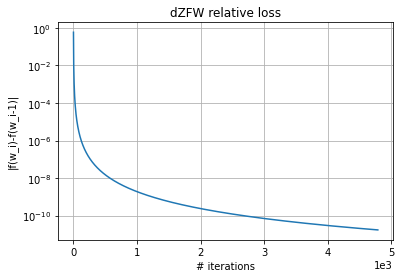

In [11]:
plt.plot(lossd)
plt.yscale("log")
plt.title("dZFW relative loss")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.grid()

## Stochastic Gradient Free Frank Wolfe on Covtype

In [12]:
%%time
fpred, f, w, mean, t, loss, f_values = stochasticZFW(F, d, w0, method = "IRDSA1", r=1, T=10, eps=1e-10)

Loss evaluation at time 1:	0.0275749

Loss evaluation at time 2:	0.0056888

Loss evaluation at time 3:	0.2195518

Loss evaluation at time 4:	0.0789956

Loss evaluation at time 5:	0.0358417

Loss evaluation at time 6:	0.1041304

Loss evaluation at time 7:	0.0282238

Loss evaluation at time 8:	0.0458985

Loss evaluation at time 9:	0.0664736

Loss evaluation at time 10:	0.0526058

CPU times: user 1.79 s, sys: 35 ms, total: 1.83 s
Wall time: 1.85 s


In [13]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.722194251100365

F(w) = 0.6695884777393749

w = [ 0.16339869  0.07843137  0.          0.          0.          0.
  0.21568627  0.1503268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.09803922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.05228758  0.          0.          0.         -0.05882353  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]

average w = [ 0.12222222  0.06666667  0.          0.          0.          0.
  0.03333333  0.14444444  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03333333
  0.          0.  

In [14]:
loss_stochm6 = np.load("../Data/results/loss_SZFWm6_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm6 = np.load("../Data/results/function_SZFWm6_lasso.npy")
f_stochm6 = f_stochm6/n

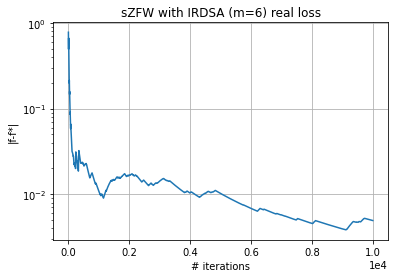

In [15]:
F_evalsm6 = np.abs(f_stochm6 - f_star)
plt.plot(F_evalsm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6) real loss")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

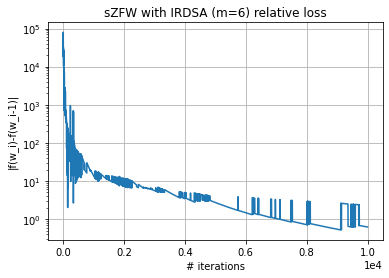

In [16]:
plt.plot(loss_stochm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6) relative loss")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

In [17]:
loss_stochm1 = np.load("../Data/results/loss_SZFWm1_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm1 = np.load("../Data/results/function_SZFWm1_lasso.npy")
f_stochm1 = f_stochm1/n

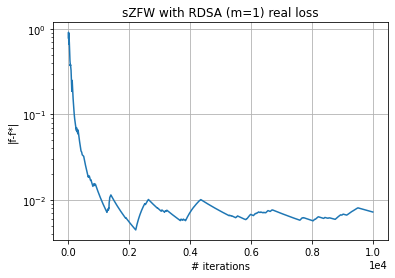

In [18]:
F_evalsm1 = np.abs(f_stochm1 - f_star)
plt.plot(F_evalsm1)
plt.yscale("log")
plt.title("sZFW with RDSA (m=1) real loss")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f-f*|")
plt.grid()

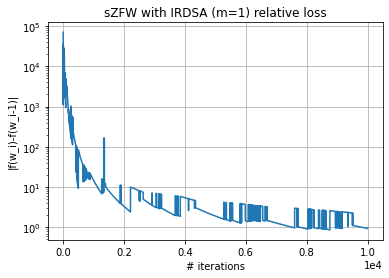

In [19]:
plt.plot(loss_stochm1)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=1) relative loss")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()

## Zeroth order stochastic accelerated gradient method with Inexact updates on Covtype

In [20]:
# setting parameters
L = 3
D = 20 # we will start from m = 6, up to T * (T+1) / D * (d+3) = 28785 (for T=100)
B = 1

In [21]:
%%time 

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 2, eps = 1e-8)

Loss evaluation at time 1:	0.0000000

CPU times: user 1.28 s, sys: 14.8 ms, total: 1.29 s
Wall time: 1.31 s


In [22]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 1.2313988351359353

F(w) = 1.2313988351359353

w = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]

average w = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]

T = 1


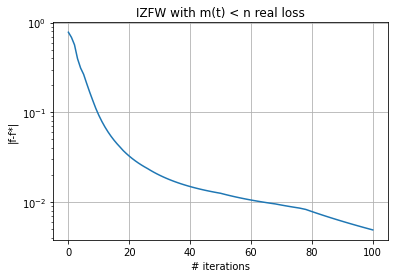

In [23]:
f_inex = np.load('../Data/results/function_IZFW_lasso_long.npy') # data from cluster
loss_inex = np.load('../Data/results/loss_IZFW_lasso_long.npy')
inner_inex = np.load('../Data/results/inner_IZFW_lasso_long.npy')
F_eval_inex = np.abs(f_inex - f_star)
plt.plot(F_eval_inex)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) < n real loss")
plt.xlabel("# iterations")
plt.grid()

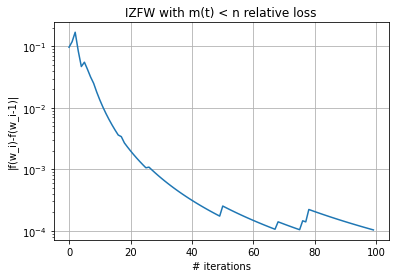

In [24]:
plt.plot(loss_inex)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) < n relative loss")
plt.xlabel("# iterations")
plt.grid()

## Result Comparison on Covtype


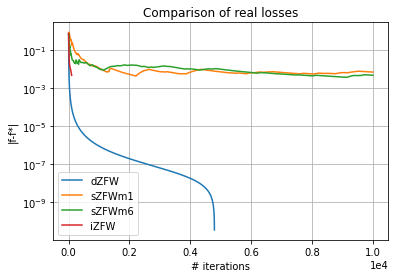

In [25]:
plt.plot(F_evald)
plt.plot(F_evalsm1)
plt.plot(F_evalsm6)
plt.plot(F_eval_inex)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW"))
plt.grid()

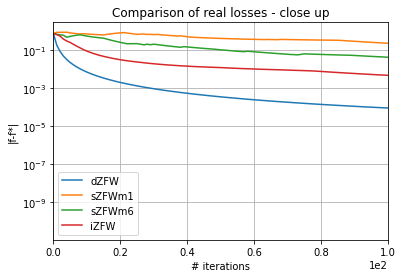

In [26]:
plt.plot(F_evald)
plt.plot(F_evalsm1)
plt.plot(F_evalsm6)
plt.plot(F_eval_inex)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.xlim((0, 100))
plt.title("Comparison of real losses - close up")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW"))
plt.grid()

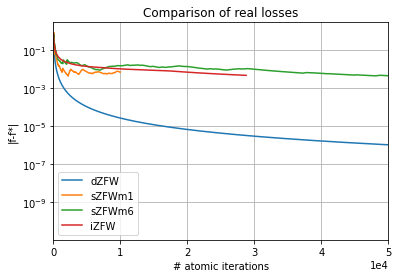

In [27]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, len(F_evald)*d, d), F_evald)
plt.plot(range(0, len(F_evalsm1)*1, 1), F_evalsm1)
plt.plot(range(0, len(F_evalsm6)*6, 6), F_evalsm6)
plt.plot([m(t)+inner_inex[t] for t in range(101)], F_eval_inex)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW"))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.xlim((0,50000))
plt.grid()

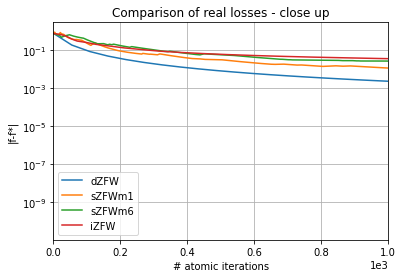

In [28]:
plt.plot(range(1, len(F_evald)*d, d), F_evald)
plt.plot(range(0, len(F_evalsm1)*1, 1), F_evalsm1)
plt.plot(range(0, len(F_evalsm6)*6, 6), F_evalsm6)
plt.plot([m(t)+inner_inex[t] for t in range(101)], F_eval_inex)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW"))
plt.yscale("log")
plt.title("Comparison of real losses - close up")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.xlim((0,1000))
plt.grid()

In [29]:
inner_inex

array([ 0, 17, 21, 21, 14, 12,  7, 12,  7, 10,  1,  1,  1,  1,  1,  1,  1,
        1,  4,  5,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  5,  1,  1,  1,  1,  1,  1,  1,  6,  1,  2,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

# Load data: artificial dataset


In [30]:
def CreateDataSet(n, d, s):
    """
    n rows, d features, s sparsity level
    """
    np.random.seed(1007)
    s = np.int(d * s)
    X = np.random.randn(n,d) 
    pn = int(s/2)
    w_s = np.concatenate((np.ones(pn), -np.ones(pn), np.zeros(d-2*pn)))
    w_s = w_s/np.sum(np.abs(w_s))
    epsilon = 0.01*np.random.rand(n) # noise
    y = X @ w_s + epsilon
    return X, y, w_s, epsilon

In [31]:
X, y, w_star, noise = CreateDataSet(n = 100, d = 1000, s = 0.05)

In [32]:
np.sum(np.abs(w_star))

1.0

In [33]:
# space dimension
d = X.shape[1]
n = y.shape[0]
f_star = F(w_star)
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")
print(f"f* = {f_star:.8f}")

Space Dimensions
d: 1000
n: 100
f* = 0.00001625


In [34]:
# initialize parameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

# starting point: center
indeces = np.random.randint(low = 0, high = d-1, size = int(d/2))
w0[indeces] = int(0)
print(f"w0: {w0[:10]}, {np.count_nonzero(w0)} elements different from zero")

w0: [0.00000000e+00 6.94725184e-05 5.32349094e-07 6.23650766e-05
 0.00000000e+00 2.30543109e-05 0.00000000e+00 4.58801767e-05
 6.46670184e-05 0.00000000e+00], 595 elements different from zero


## Deterministic Gradient Free Frank Wolfe on Artificial Dataset

In [35]:
# Lipshitz constant 
L = 2/X.shape[0] * np.linalg.norm(X.T @ X)
print(L)

208.6239595944219


In [36]:
%%time

# Lipschitz constant 

fpred, f, w, mean, t, loss, f_valuesd = detZFW(F, L, d, w0, T=1000, eps = 1e-8)

Loss evaluation at time 1:	0.2869688

Loss evaluation at time 2:	0.2624069

Loss evaluation at time 3:	0.0283229

Loss evaluation at time 4:	0.0363124

Loss evaluation at time 5:	0.0025483

Loss evaluation at time 6:	0.0077457

Loss evaluation at time 7:	0.0023958

Loss evaluation at time 8:	0.0006643

Loss evaluation at time 9:	0.0035124

Loss evaluation at time 10:	0.0015967

Loss evaluation at time 11:	0.0036494

Loss evaluation at time 12:	0.0023726

Loss evaluation at time 13:	0.0035014

Loss evaluation at time 14:	0.0010940

Loss evaluation at time 15:	0.0018221

Loss evaluation at time 16:	0.0000485

Loss evaluation at time 17:	0.0014287

Loss evaluation at time 18:	0.0023645

Loss evaluation at time 19:	0.0007307

Loss evaluation at time 20:	0.0011386

Loss evaluation at time 21:	0.0002368

Loss evaluation at time 22:	0.0005389

Loss evaluation at time 23:	0.0001284

Loss evaluation at time 24:	0.0002807

Loss evaluation at time 25:	0.0003878

Loss evaluation at time 26:	0.0004

In [37]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376754

F(w_pred) = 0.0001572218539217139

F(w) = 0.00015722510307105125

w = [ 0.00000000e+00  2.19669002e-09  1.68326407e-11  1.97195588e-09
  0.00000000e+00  6.60848742e-03  0.00000000e+00  1.45071070e-09
  3.69948981e-03  0.00000000e+00  0.00000000e+00  4.74515930e-10
  7.92202773e-10  1.42048216e-09  2.24498830e-03  2.63663869e-09
  2.16029669e-09  0.00000000e+00  0.00000000e+00  9.68511210e-10
  0.00000000e+00  7.27249923e-03  0.00000000e+00  2.29969919e-10
  2.68046521e-09  2.71493511e-09  1.97556516e-09  4.74539905e-10
 -2.08688928e-03 -5.47018276e-03  0.00000000e+00 -2.44419149e-02
  0.00000000e+00  1.36442998e-09 -4.64807437e-03  0.00000000e+00
 -2.40624782e-02  2.54195325e-10  1.46595254e-09 -4.90103080e-03
  0.00000000e+00  2.70281978e-09 -3.41491178e-03  6.71313771e-10
 -6.98792133e-03  0.00000000e+00 -1.07190286e-02  2.33145447e-09
  1.47518269e-09  1.43269332e-10  0.00000000e+00 -7.11439890e-03
  0.00000000e+00  2.30688825e-09  2.00583715e-

In [38]:
loss_ad = np.load("../Data/results/loss_dZFW_lasso_AD.npy")
f_valuesd = np.load("../Data/results/function_dZFW_lasso_AD.npy")

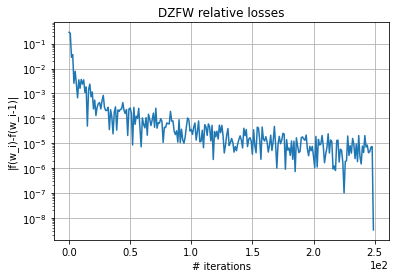

In [39]:
plt.plot(loss_ad)
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title("DZFW relative losses")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.xlabel("# iterations")
plt.grid()

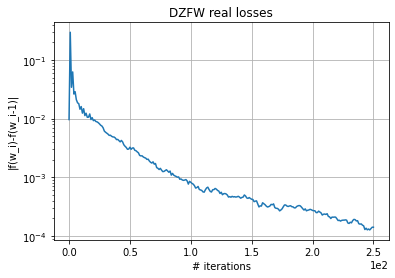

In [40]:
plt.plot(f_valuesd - f_star)
plt.yscale("log")
plt.title("DZFW real losses")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()

## Stochastic Gradient Free Frank Wolfe on Artificial Dataset

In [41]:
%%time
fpred, f, w, mean, t, lossm1ad, f_valuessm1ad = stochasticZFW(F, d, w0, method = "RDSA", r=1, T=10000, eps=1e-8)

Loss evaluation at time 1:	0.0251493

Loss evaluation at time 2:	0.0103963

Loss evaluation at time 3:	0.0084094

Loss evaluation at time 4:	0.0316299

Loss evaluation at time 5:	0.0128758

Loss evaluation at time 6:	0.0335173

Loss evaluation at time 7:	0.0196860

Loss evaluation at time 8:	0.0120568

Loss evaluation at time 9:	0.0023602

Loss evaluation at time 10:	0.0104461

Loss evaluation at time 11:	0.0031741

Loss evaluation at time 12:	0.0137573

Loss evaluation at time 13:	0.0024111

Loss evaluation at time 14:	0.0076494

Loss evaluation at time 15:	0.0087941

Loss evaluation at time 16:	0.0027370

Loss evaluation at time 17:	0.0011948

Loss evaluation at time 18:	0.0068289

Loss evaluation at time 19:	0.0051005

Loss evaluation at time 20:	0.0005636

Loss evaluation at time 21:	0.0026952

Loss evaluation at time 22:	0.0050128

Loss evaluation at time 23:	0.0010362

Loss evaluation at time 24:	0.0025756

Loss evaluation at time 25:	0.0052413

Loss evaluation at time 26:	0.0071

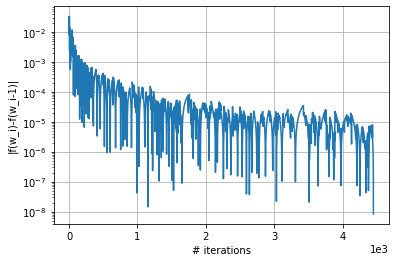

In [42]:
plt.plot(lossm1ad)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()

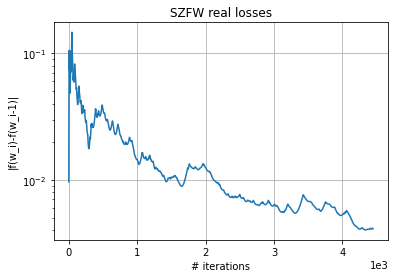

In [43]:
plt.plot(f_valuessm1ad - f_star)
plt.yscale("log")
plt.title("SZFW real losses")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()

In [44]:
%%time
fpred, f, w, mean, t, loss, f_valuess = stochasticZFW(F, d, w0, method = "IRDSA2", r=1, T=1000, eps=1e-8)

Loss evaluation at time 1:	0.0179398

Loss evaluation at time 2:	0.0074412

Loss evaluation at time 3:	0.0040208

Loss evaluation at time 4:	0.0049417

Loss evaluation at time 5:	0.0047129

Loss evaluation at time 6:	0.0134573

Loss evaluation at time 7:	0.0065697

Loss evaluation at time 8:	0.0057294

Loss evaluation at time 9:	0.0010003

Loss evaluation at time 10:	0.0033828

Loss evaluation at time 11:	0.0019378

Loss evaluation at time 12:	0.0054339

Loss evaluation at time 13:	0.0041329

Loss evaluation at time 14:	0.0032661

Loss evaluation at time 15:	0.0008378

Loss evaluation at time 16:	0.0020255

Loss evaluation at time 17:	0.0027135

Loss evaluation at time 18:	0.0007207

Loss evaluation at time 19:	0.0012784

Loss evaluation at time 20:	0.0002186

Loss evaluation at time 21:	0.0028544

Loss evaluation at time 22:	0.0008502

Loss evaluation at time 23:	0.0006759

Loss evaluation at time 24:	0.0002669

Loss evaluation at time 25:	0.0008200

Loss evaluation at time 26:	0.0045

In [45]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376754

F(w_pred) = 0.0003842406209048937

F(w) = 0.0003899405757719432

w = [ 0.00000000e+00  3.83275507e-09  7.06759039e-03  2.97914942e-03
  0.00000000e+00  5.48147224e-03  1.13136615e-02  2.53118044e-09
  1.17865454e-02  6.52968900e-03  0.00000000e+00  8.27928987e-10
  1.38222470e-09  2.26590962e-04  3.47567031e-03  4.60037158e-09
  3.49734776e-03  0.00000000e+00  3.53478035e-03  1.68984528e-09
  0.00000000e+00  2.34076090e-03  0.00000000e+00  4.01248409e-10
  4.67683949e-09  4.73698212e-09  3.44693940e-09 -2.66980261e-03
 -1.64522723e-03 -3.36927224e-04  0.00000000e+00 -5.94646995e-03
 -1.66099210e-03  2.38063900e-09 -4.36823190e-03  0.00000000e+00
 -8.03892963e-04  4.43516570e-10  2.55777419e-09 -1.18791476e-02
  0.00000000e+00  5.32037512e-05 -1.56740121e-02  1.17129920e-09
  0.00000000e+00  0.00000000e+00 -3.29242919e-03  4.06789028e-09
  2.57387884e-09 -1.34967898e-03  0.00000000e+00  1.13001903e-09
  0.00000000e+00  2.94565431e-03  3.49975757e-0

In [46]:
loss_sad = np.load("../Data/results/loss_SZFW_lasso_AD.npy")
f_valuess = np.load("../Data/results/function_SZFW_lasso_AD.npy")

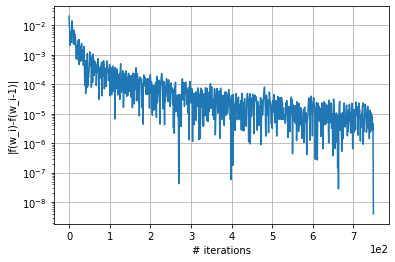

In [47]:
plt.plot(loss_sad)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()

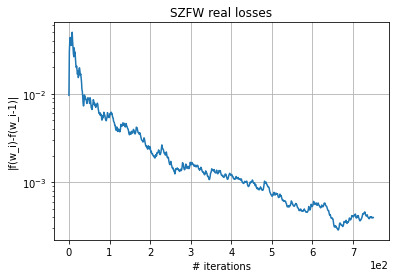

In [48]:
plt.plot(f_valuess - f_star)
plt.yscale("log")
plt.title("SZFW real losses")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()

## Zeroth order stochastic accelerated gradient method with Inexact updates on Artificial Dataset

In [49]:
# setting parameters: UPDATE WITH THE FINAL ONES
B = 1 
L = 0.1
D = 10000

In [50]:
%%time 

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 5, eps = 1e-8)


'''
with max iter = 100, m(101) = 1034

F(w_pred) = 0.01524209692890398

F(w) = 0.01502719283827

w = ***too long***

average w = ***too long***

T = 100
0.009651865274889974 0.01502719283827

--------------------------------------

with max iter = 1000, m(1001) = 100602

***Add .res***
'''

Loss evaluation at time 1:	0.0298468

Loss evaluation at time 2:	0.0110395

Loss evaluation at time 3:	0.0145498

Loss evaluation at time 4:	0.0207854

Loss evaluation at time 5:	0.0160935

CPU times: user 8.18 s, sys: 1.26 s, total: 9.45 s
Wall time: 2.88 s


'\nwith max iter = 100, m(101) = 1034\n\nF(w_pred) = 0.01524209692890398\n\nF(w) = 0.01502719283827\n\nw = ***too long***\n\naverage w = ***too long***\n\nT = 100\n0.009651865274889974 0.01502719283827\n\n--------------------------------------\n\nwith max iter = 1000, m(1001) = 100602\n\n***Add .res***\n'

In [51]:
loss_i = np.load("../Data/results/loss_IZFW_AD_long.npy")
f_i = np.load("../Data/results/function_IZFW_AD_long.npy")
inner_i = np.load("../Data/results/inner_IZFW_AD_long.npy")

In [52]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 0.03470224745273643

F(w) = 0.018608765635130108

w = [ 0.00000000e+00  3.30821516e-06  2.53499568e-08  2.96976555e-06
  0.00000000e+00  1.09782433e-06  0.00000000e+00  2.18477032e-06
  3.07938183e-06  0.00000000e+00  0.00000000e+00  7.14620991e-07
  1.19305738e-06  2.13924613e-06  0.00000000e+00  3.97077787e-06
  3.25340682e-06  0.00000000e+00  0.00000000e+00  1.45857788e-06
  0.00000000e+00  2.88816726e-06  0.00000000e+00  3.46334698e-07
  4.03678060e-06  4.08869228e-06  2.97520112e-06  7.14657097e-07
  1.89428307e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.05483155e-06  0.00000000e+00  0.00000000e+00
  3.08238832e-06  3.82818159e-07  2.20772452e-06  0.00000000e+00
  0.00000000e+00  4.07044659e-06  0.00000000e+00  1.01099854e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.51117044e-06
  2.22162514e-06  2.15763613e-07  0.00000000e+00  9.75367850e-07
  0.00000000e+00  3.47417370e-06  3.02079075e-06  1.00053905e-06
  9.19695572e-0

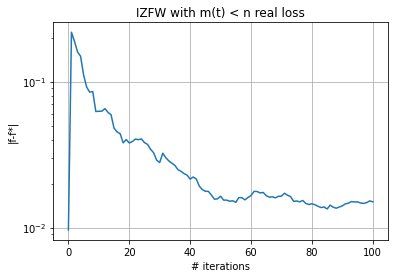

In [53]:
F_eval_i = np.abs(f_i - f_star)
plt.plot(F_eval_i)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) < n real loss")
plt.xlabel("# iterations")
plt.grid()

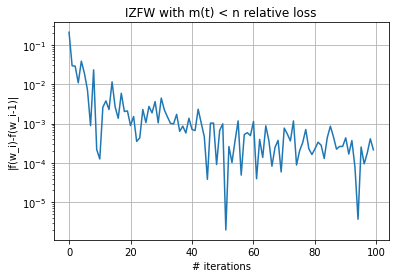

In [54]:
plt.plot(loss_i)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) < n relative loss")
plt.xlabel("# iterations")
plt.grid()

In [55]:
loss_i1000 = np.load("../Data/results/loss_IZFW_AD_long_1000.npy")
f_i1000 = np.load("../Data/results/function_IZFW_AD_long_1000.npy")
inner_i1000 = np.load("../Data/results/inner_IZFW_AD_long_1000.npy")

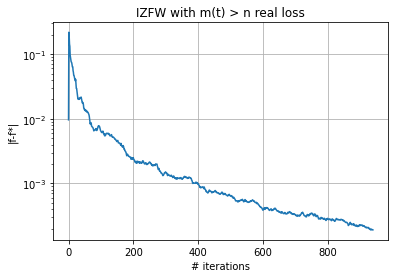

In [56]:
F_eval_i1000 = np.abs(f_i1000 - f_star)
plt.plot(F_eval_i1000)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) > n real loss")
plt.xlabel("# iterations")
plt.grid()

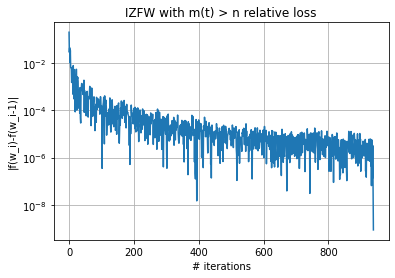

In [57]:
plt.plot(loss_i1000)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) > n relative loss")
plt.xlabel("# iterations")
plt.grid()

## Comparisons among all methods on Artificial Dataset

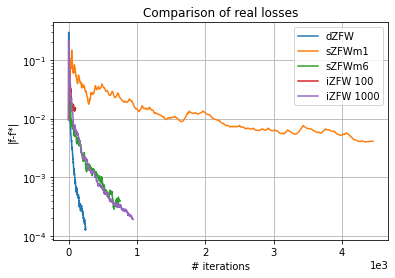

In [58]:
F_d = np.abs(f_valuesd - f_star)
F_sm1 = np.abs(f_valuessm1ad - f_star)
F_s = np.abs(f_valuess - f_star)
F_i = np.abs(f_i - f_star)
F_i1000 = np.abs(f_i1000 - f_star)
plt.plot(F_d)
plt.plot(F_sm1)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW 100", "iZFW 1000"))
plt.xlabel('# iterations')
plt.ylabel('|f-f*|')
plt.grid()

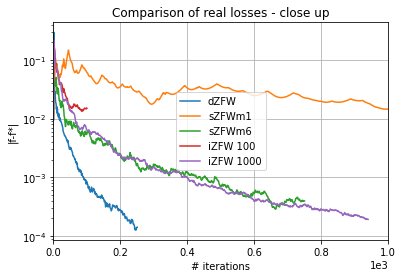

In [62]:
plt.plot(F_d)
plt.plot(F_sm1)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses - close up 1")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.xlim((0,1000))
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW 100", "iZFW 1000"))
plt.grid()

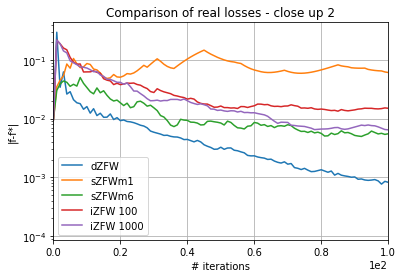

In [63]:
plt.plot(F_d)
plt.plot(F_sm1)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses - close up 2")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.xlim((0,100))
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", "iZFW 100", "iZFW 1000"))
plt.grid()

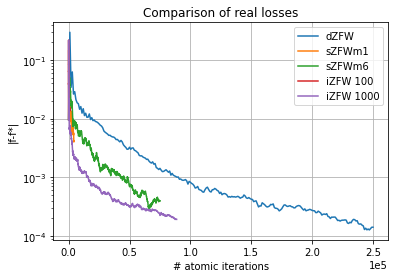

In [60]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, 251*d, d), F_d)
plt.plot(range(len(F_sm1)),F_sm1)
plt.plot(range(0, 750*100+1, 100), F_s)
plt.plot([m(t)+inner_i[t] for t in range(101)], F_i)
plt.plot([m(t)+inner_i1000[t] for t in range(len(inner_i1000))], f_i1000 - f_star)
plt.yscale("log")
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", 'iZFW 100','iZFW 1000'))
plt.grid()

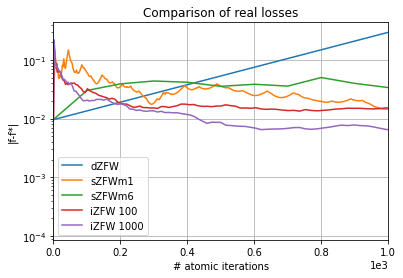

In [61]:
plt.plot(range(1, 251*d, d), F_d)
plt.plot(range(len(F_sm1)),F_sm1)
plt.plot(range(0, 750*100+1, 100), F_s)
plt.plot([m(t)+inner_i[t] for t in range(101)], F_i)
plt.plot([m(t)+inner_i1000[t] for t in range(len(inner_i1000))], f_i1000 - f_star)
plt.yscale("log")
plt.xlim((0, 1000))
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFWm1', "sZFWm6", 'iZFW 100','iZFW 1000'))
plt.grid()